In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import random
import itertools
import datetime
import pytz
from pytz import timezone

First, let's read in the data. Because of its large size, we have to use chunksize with pd.concat in order to read everything. However, that takes a long time, and the dataframe is too big to be saved in one chunk. Instead, we try using HDF5 to store and read our dataframe efficiently.

In [67]:
#df = pd.concat(pd.read_json('combined_day', lines=True, chunksize=100000))
store = pd.HDFStore('combined_day.h5')
#store['df'] = df  # save it
df = store['df']  # load it

Now let's do some low level preprocessing. Any rows where c_cnt is NaN must be removed as they are useless. Any columns that contain only one unique value give no information, and so are dropped. 

In [46]:
#Drop all rows where c_cnt is NaN
df = df[np.isfinite(df['c_cnt'])]
#Drop all columns where nunique() == 1
for c in df.columns:
    try:
        if df[c].nunique() < 2:
            print("Column ", c, "only has 1 unique value, so we are dropping it")
            df = df.drop(c, axis=1)
    except:
        pass
df.shape

Column  adlog_count only has 1 unique value, so we are dropping it
Column  cr_cnt only has 1 unique value, so we are dropping it
Column  f_nfr only has 1 unique value, so we are dropping it
Column  flag only has 1 unique value, so we are dropping it
Column  is_bot only has 1 unique value, so we are dropping it
Column  is_fraud only has 1 unique value, so we are dropping it
Column  preview only has 1 unique value, so we are dropping it
Column  pub_campaign_id only has 1 unique value, so we are dropping it
Column  r_num_ads_third_party only has 1 unique value, so we are dropping it
Column  tag_value only has 1 unique value, so we are dropping it
Column  vv_cnt only has 1 unique value, so we are dropping it


(1724754, 64)

Let's take a look at the columns in terms of their non-NaN values.

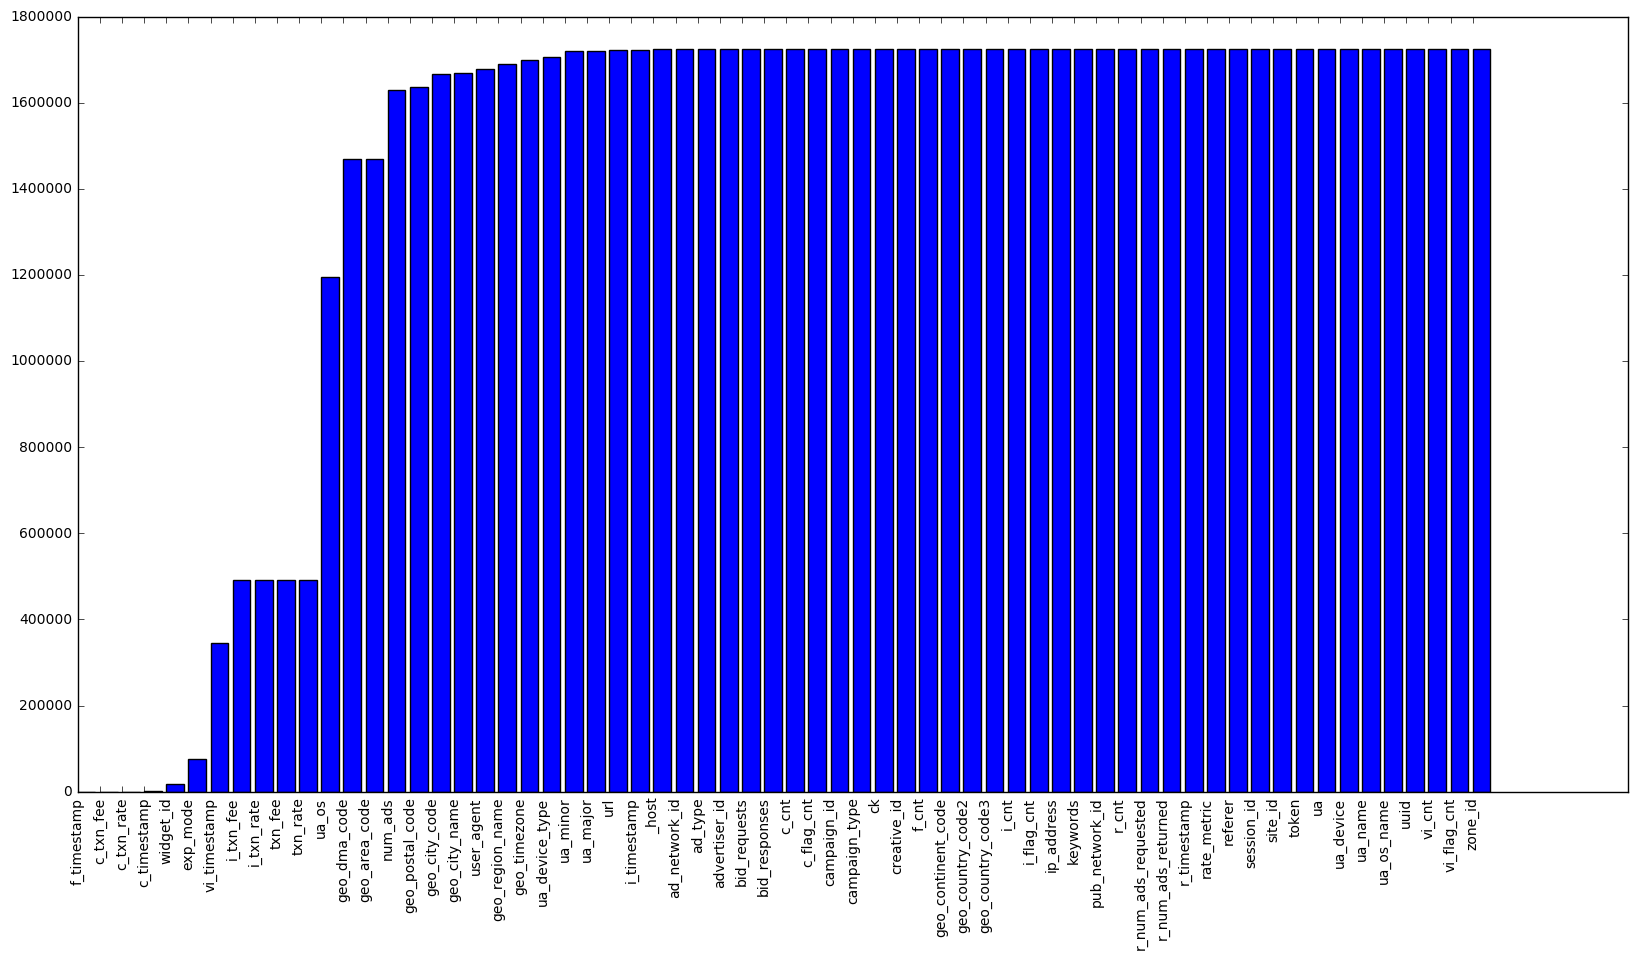

In [27]:
countx, county = [c for c in df.columns], [df[c].count() for c in df.columns]
countx = [x for _, x in sorted(zip(county, countx))]
county = sorted(county)
plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(countx))], county)
plt.xticks([i for i in range(len(countx))], countx, rotation=90)
plt.show()

We want our dataframe to contain 0 NaN values. It is apparent that removing the first few columns in the plot above would result in almost no loss of information while removing a ton of NaN values. However, the question is whether we should keep or remove ua_os. I decided to remove it as well, since basically 66% of the time, it is NaN, but feel free to decide against this.

If we were to keep ua_os, we must set some value to replace the NaN values it has. Usually, you would set NaNs to 0 or the mean of the column, but since our data is categorical, it would make the most sense to set it as our most frequent class. However, since 66% of the data is NaNs, we would be making a huge assumption on the ua_os feature if we set every NaN to a certain value, and this is very vulnerable to overfitting. 

Another option is to create a new class for ua_os, maybe call it 'NaN'. However, again, since 66% of our data in this feature are NaNs, we are still vulnerable to overfitting.

In [65]:
#drop columns that are more than 30% NaN populated
df = df.drop([c for c in df.columns if df[c].count() < df.shape[0] * 0.7],axis=1)

Before we start removing all samples that contain NaN values, we must first consider the effect this will have on our data. We have a TON of negative classes - so really, we just want to preserve as many positive samples as possible. Below, for each column, we find how many NaN instances of that column exists in positive samples, as well as how many NaN instances of that column exists in total. The resulting plot and code is below. 

In [63]:
print(sum(df['c_cnt'].values))
count = {}
for i in df.columns:
    count[i] = 0
for i in range(len(df)):
    if df['c_cnt'].values[i] == 1:
        for c in df.columns:
            if isinstance(df[c].values[i], float) and math.isnan(df[c].values[i]):
                count[c] += 1
print(count)

1185.0
{'geo_area_code': 416, 'geo_timezone': 17, 'widget_id': 1054, 'bid_responses': 0, 'geo_region_name': 35, 'url': 0, 'advertiser_id': 0, 'r_num_ads_requested': 0, 'ua_device': 0, 'r_timestamp': 0, 'txn_rate': 0, 'geo_city_code': 41, 'r_cnt': 0, 'ad_type': 0, 'geo_country_code2': 0, 'keywords': 0, 'session_id': 0, 'f_timestamp': 1185, 'geo_country_code3': 0, 'user_agent': 90, 'referer': 0, 'ad_network_id': 0, 'geo_continent_code': 0, 'campaign_type': 0, 'pub_network_id': 0, 'c_txn_rate': 757, 'zone_id': 0, 'rate_metric': 0, 'num_ads': 594, 'geo_city_name': 41, 'ua_major': 4, '_host': 0, 'ua_os_name': 0, 'bid_requests': 0, 'i_flag_cnt': 0, 'vi_cnt': 0, 'ua_name': 0, 'ua_minor': 4, 'txn_fee': 0, 'c_cnt': 0, 'ip_address': 0, 'site_id': 0, 'i_txn_rate': 428, 'vi_flag_cnt': 0, 'uuid': 0, 'exp_mode': 615, 'campaign_id': 0, 'c_timestamp': 0, 'vi_timestamp': 398, 'c_flag_cnt': 0, 'token': 0, 'ua': 0, 'i_timestamp': 0, 'geo_dma_code': 416, 'c_txn_fee': 757, 'ua_device_type': 18, 'i_cnt': 0,

In [64]:
for c in count:
    print(c, count[c], df[c].count())

geo_area_code 416 1470222
geo_timezone 17 1698604
widget_id 1054 17978
bid_responses 0 1724754
geo_region_name 35 1689619
url 0 1722411
advertiser_id 0 1724754
r_num_ads_requested 0 1724754
ua_device 0 1724754
r_timestamp 0 1724754
txn_rate 0 492050
geo_city_code 41 1667604
r_cnt 0 1724754
ad_type 0 1724754
geo_country_code2 0 1724754
keywords 0 1724754
session_id 0 1724754
f_timestamp 1185 2
geo_country_code3 0 1724754
user_agent 90 1677621
referer 0 1724754
ad_network_id 0 1724754
geo_continent_code 0 1724754
campaign_type 0 1724754
pub_network_id 0 1724754
c_txn_rate 757 429
zone_id 0 1724754
rate_metric 0 1724754
num_ads 594 1629081
geo_city_name 41 1668405
ua_major 4 1720986
_host 0 1724754
ua_os_name 0 1724754
bid_requests 0 1724754
i_flag_cnt 0 1724754
vi_cnt 0 1724754
ua_name 0 1724754
ua_minor 4 1720824
txn_fee 0 492050
c_cnt 0 1724754
ip_address 0 1724754
site_id 0 1724754
i_txn_rate 428 491621
vi_flag_cnt 0 1724754
uuid 0 1724754
exp_mode 615 77034
campaign_id 0 1724754
c_ti